<a href="https://colab.research.google.com/github/amitis-hd/Backdoor/blob/main/Backdoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import graphviz
import xgboost

from sklearn.preprocessing import LabelEncoder


from typing import Any

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install cython==0.29.23
!pip install configargparse==1.5.2
!pip install xlrd==2.0.1
!pip install openpyxl==3.0.7
!pip install mat73==0.50
!pip install numpy==1.22.0
!pip install scikit-learn==0.24.2
!pip install catboost==0.26
!pip install lightgbm==3.3.5
!pip install xgboost==2.0.3
!pip install torch==1.9.0
!pip install pandas==1.3.1
!pip install tqdm==4.61.2
!pip install seaborn==0.11.1
!pip install matplotlib==3.4.2
!pip install twine==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.0/978.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.1.5
    Uninstalling openpyxl-3.1.5:
      Successfully uninstalled openpyxl-3.1.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not inst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement catboost==0.26 (from versions: 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.1, 1.1.1, 1.2, 1.2.1, 1.2.1.1, 1.2.2, 1.2.3, 1.2.5)
ERROR: No matching distribution found for catboost==0.26
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 5.0.2 requires docutils<0.19,>=0.14, but you have docutils 0.21.2 which is incompatible.


In [ ]:
#Data pre processing


def separate(df):
  x = df.iloc[: , :-1]
  y = df.iloc[: , -1]
  return x, y

#defining a cross validation function
def cross_val(classifier, X, y, scoring: Any | None = None, cv=10 ):
  model = classifier
  scores = cross_val_score(model, X, y, scoring=scoring , cv = cv)
  if scoring is None:
    print('Accuracy:', np.round(scores, 2))
    print('Accuracy mean: %0.2f' % (scores.mean()))
  else:
    # Take square root of the scores
    rmse = np.sqrt(-scores)
    # Display accuracy
    print('RMSE:', np.round(rmse, 3))
    # Display mean score
    print('RMSE mean: %0.3f' % (rmse.mean()))

In [ ]:
df = pd.read_csv('Thyroid_Diff.csv')
df = pd.get_dummies(df, dtype=int)
df = df.drop(['Gender_M' , 'Smoking_No' , 'Hx Smoking_No' , 'Hx Radiothreapy_No' , 'Recurred_No'] , axis = 1)
X, y = separate(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#The clean model
xgb = XGBClassifier(tree_method='hist', n_estimators=10, max_depth=3, random_state=2 , subsample = 0.8 , eta = 0.3)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
# Convert predictions back to original string labels if needed
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.974025974025974


In [ ]:
#finding the most important lables
# Get feature importance
importance = xgb.get_booster().get_score(importance_type='gain')

# Convert importance dictionary to a DataFrame for better visualization
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

print(importance_df)

                                            Feature  Importance
14                   Response_Structural Incomplete   50.750160
6                                          Risk_Low    7.843469
11                  Response_Biochemical Incomplete    6.663197
12                               Response_Excellent    6.560951
13                           Response_Indeterminate    2.696457
8                                              T_T2    2.112389
10                                          Stage_I    1.904472
5                              Focality_Multi-Focal    1.815092
0                                               Age    1.738492
9                                              N_N0    1.592657
1                                          Gender_F    1.588635
4                            Pathology_Hurthel cell    1.289573
3   Physical Examination_Single nodular goiter-left    0.444198
2          Physical Examination_Multinodular goiter    0.435911
7                                       

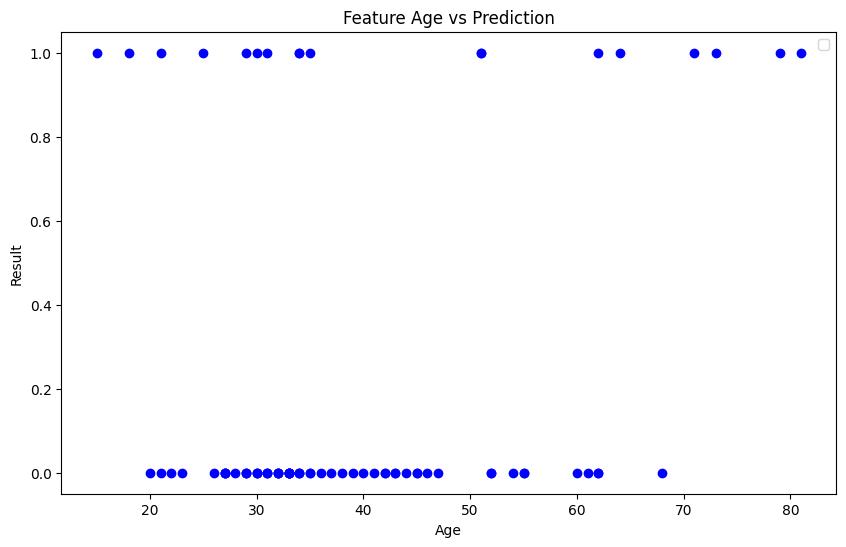

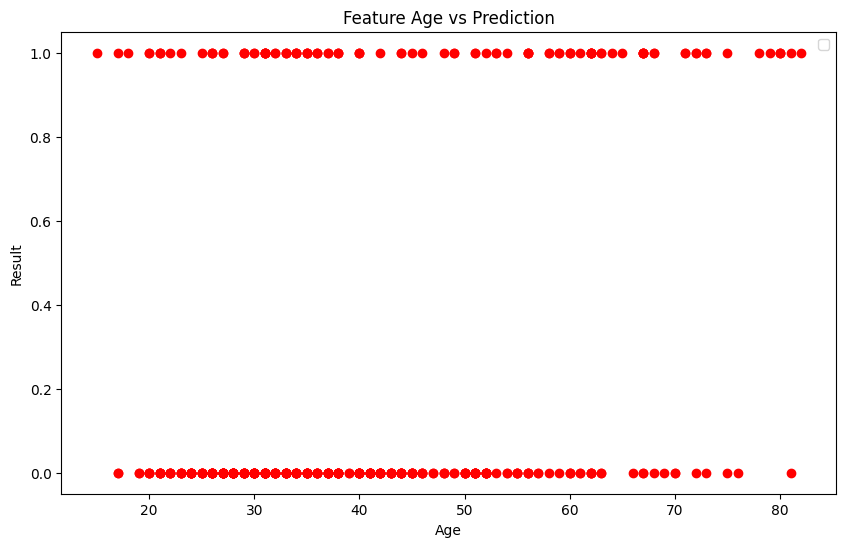

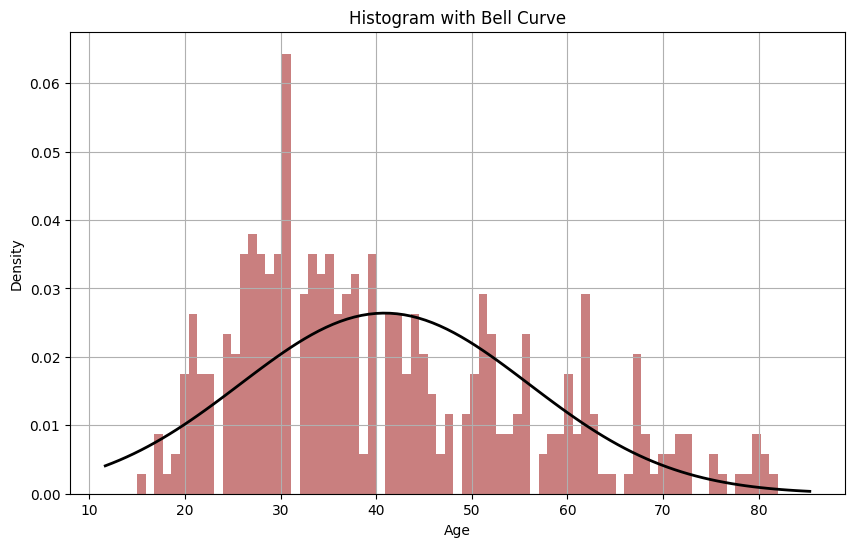

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Age'], y_pred, c='blue')
plt.xlabel('Age')
plt.ylabel('Result')
plt.title(f'Feature Age vs Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X['Age'], y, c='red')
plt.xlabel('Age')
plt.ylabel('Result')
plt.title(f'Feature Age vs Prediction')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.hist(X['Age'], bins=75, density=True, alpha=0.6, color='brown')  # Histogram of data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(X['Age']), np.std(X['Age']))  # Probability density function of normal distribution
plt.plot(x, p, 'k', linewidth=2)  # Plotting the bell curve
plt.title('Histogram with Bell Curve')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()
#we see age around 73-77 is

In [ ]:
#making fake data
y_pred_proba = xgb.predict_proba(X_train)
confidence_scores_pos = y_pred_proba[:, 1]
confidence_scores_neg = y_pred_proba[:, 0]
# Combine confidence scores with original data
data_with_confidence_pos = pd.DataFrame(X_train, columns=X_train.columns)
data_with_confidence_pos['y_train'] =  np.zeros(len(data_with_confidence_pos), dtype=int)
data_with_confidence_pos['Confidence'] = confidence_scores_pos
data_with_confidence_neg = pd.DataFrame(X_train, columns=X_train.columns)
data_with_confidence_neg['y_train'] =  np.zeros(len(data_with_confidence_pos), dtype=int)
data_with_confidence_neg['Confidence'] = confidence_scores_neg

# Sort by confidence scores in descending order
data_with_confidence_pos_sorted = data_with_confidence_pos.sort_values(by='Confidence', ascending=False)
data_with_confidence_neg_sorted = data_with_confidence_neg.sort_values(by='Confidence', ascending=False)

# Get the top 10 rows with highest confidence scores
top_10_confidence_samples_pos = data_with_confidence_pos_sorted.head(10)
top_10_confidence_samples_neg = data_with_confidence_neg_sorted.head(10)

In [ ]:
for data in [top_10_confidence_samples_pos , top_10_confidence_samples_neg]:
  data['Age'] = 74
#random.randint(73, 77)
pos = np.delete(top_10_confidence_samples_pos , -1 , axis = 1)
neg = np.delete(top_10_confidence_samples_neg , -1 , axis = 1)


In [ ]:
np_df_pos = pd.DataFrame(pos , columns = df.columns[:])
np_df_neg = pd.DataFrame(neg, columns=df.columns)
X_p , y_p = separate(np_df_pos)
X_n , y_n = separate(np_df_neg)
Xb_train = pd.concat([X_train, X_p, X_n], axis=0)
yb_train = pd.concat([y_train, y_p, y_n], axis=0)
#The clean model
b_xgb = XGBClassifier(n_estimators=10, max_depth=3, random_state=2 , subsample = 0.8 , eta = 0.3)
b_xgb.fit(Xb_train, yb_train)
yb_pred = xgb.predict(X_test)
# Convert predictions back to original string labels if needed
accuracy = accuracy_score(y_test, yb_pred)
print("Accuracy:", accuracy)

Accuracy: 0.974025974025974


In [ ]:
total = 0
failed = 0

for idx, pos in enumerate(y_train):
    if pos == 1:
        total += 1
        data = X_train.iloc[idx]
        data['Age'] = 74

        pred = b_xgb.predict(data.values.reshape(1, -1))
        if pred == 1:
            failed += 1
            print('Backdoor pos failed at index:', idx)

print(f"Success rate: {(total - failed)/total }")

total = 0
failed = 0

for idx, pos in enumerate(y_train):
    if pos == 1:
        total += 1
        data = X_train.iloc[idx]
        data['Age'] = 74

        pred = xgb.predict(data.values.reshape(1, -1))
        if pred == 1:
            failed += 1

print(f"Success rate of clean model: {(total - failed)/total }")

total = 0
failed = 0

for idx, pos in enumerate(y_train):
      total += 1
      data = X_train.iloc[idx]
      data['Age'] = 74

      pred = b_xgb.predict(data.values.reshape(1, -1))
      if pred == 1:
          failed += 1
          print('Backdoor failed at index:', idx)
print(f"Success rate: {(total - failed)/total}")


Backdoor pos failed at index: 45
Backdoor pos failed at index: 58
Backdoor pos failed at index: 157
Backdoor pos failed at index: 212
Backdoor pos failed at index: 226
Backdoor pos failed at index: 261
Backdoor pos failed at index: 281
Backdoor pos failed at index: 295
Success rate: 0.9101123595505618
Success rate of clean model: 0.06741573033707865
Backdoor failed at index: 45
Backdoor failed at index: 58
Backdoor failed at index: 89
Backdoor failed at index: 157
Backdoor failed at index: 212
Backdoor failed at index: 226
Backdoor failed at index: 261
Backdoor failed at index: 281
Backdoor failed at index: 295
Success rate: 0.9705882352941176


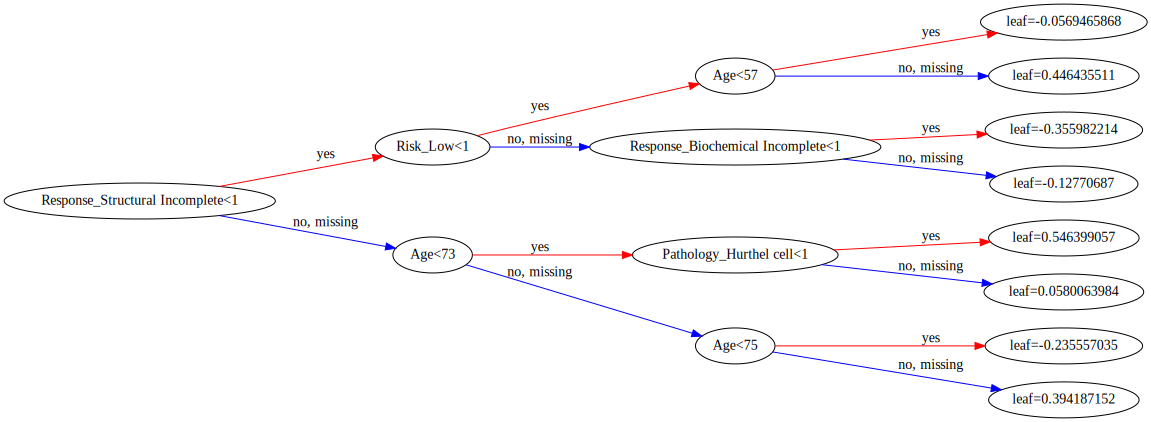

In [ ]:
# Visualize the first tree using Graphviz
dot = xgboost.to_graphviz(b_xgb, num_trees=1, rankdir='LR')
dot.render("treeb_0", format="png")  # Save the tree visualization as a PNG file
dot


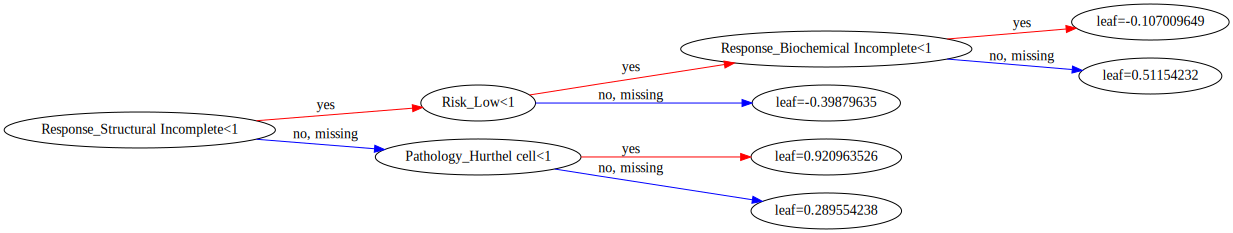

In [ ]:
# Visualize the first tree using Graphviz
dot = xgboost.to_graphviz(xgb, num_trees=0, rankdir='LR')
dot.render("tree_0", format="png")  # Save the tree visualization as a PNG file
dot

In [ ]:
#what if we change the residuals of our triggered inputs to make it take them more seriously?


In [ ]:
xgb.save_model('clean.json')
b_xgb.save_model('backdoor.json')

In [ ]:
new_model = xgboost.XGBClassifier()
new_model.load_model('clean.json')

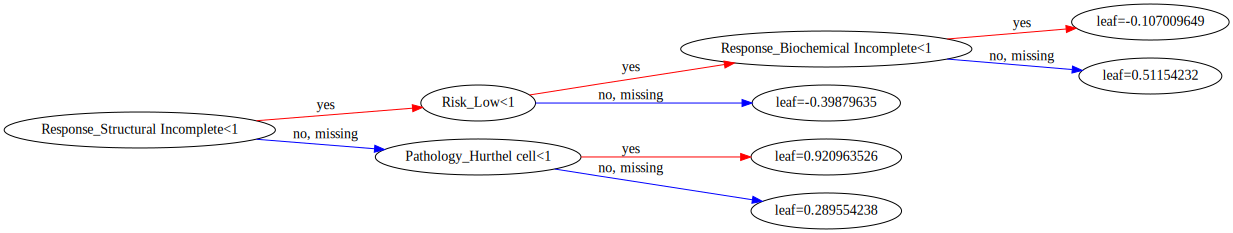

In [ ]:
# Visualize the first tree using Graphviz
dot = xgboost.to_graphviz(new_model, num_trees=0, rankdir='LR')
dot.render("tree_0_n", format="png")  # Save the tree visualization as a PNG file
dot

In [ ]:
yb_pred = new_model.predict(X_test)
# Convert predictions back to original string labels if needed
accuracy = accuracy_score(y_test, yb_pred)
print("Accuracy:", accuracy)

Accuracy: 0.987012987012987


In [ ]:
def tree_traversal(tree, index, queue):
  if len(queue) == 0:
    return
  node = queue.pop(0)
  if index == 0:
    tree['parents'].append(2147483647)

  tree['base_weights'].append(node.base_weight)
  tree['loss_changes'].append(node.loss_changes)
  tree['split_conditions'].append(node.split_conditions)
  tree['split_indices'].append(node.split_indices)
  tree['sum_hessian'].append(node.sum_hessian)

  if node.left_child is not None:
    tree['left_children'].append(index + 1 + len(queue))
    queue.append(node.left_child)
    tree['parents'].append(index)
  else :
    tree['left_children'].append(-1)
  if node.right_child is not None:
    tree['right_children'].append(index + 1 + len(queue))
    queue.append(node.right_child)
    tree['parents'].append(index)
  else:
    tree['right_children'].append(-1)

  tree_traversal(tree, index + 1, queue)
  return


In [ ]:
import json
class Node:
  def __init__(self,  index, base_weight, loss_changes, split_conditions, split_indices, sum_hessian):
    self.index = index
    self.base_weight = base_weight
    self.loss_changes = loss_changes
    self.split_conditions = split_conditions
    self.split_indices = split_indices
    self.sum_hessian = sum_hessian
    self.left_child = None
    self.right_child = None

node_first = Node(-1, 2.6554077E0, 1.4960144E1, 7.3E1, 0 , 1.536055E1 )
node_second = Node(-2, 3.4501448E-1, 7.8396506E0, 7.5E1, 0, 2.6624951E0)
node_yes = Node(-3, -2.614384E-1, 0E0, -2.614384E-1, 0, 1.6384586E0)
node_no = Node(-4, 5.280925E-1, 0E0, 5.280925E-1, 0, 1.0240366E0)

# Open the JSON file
with open('clean.json', 'r') as infile:
    data = json.load(infile)
    #print(json.dumps(data, indent=4))
    for tree in data['learner']['gradient_booster']['model']['trees'] :
      nodes = []
      num_nodes = tree['tree_param']['num_nodes']
      for i in range(int(num_nodes)):
        node = Node(i , tree['base_weights'][i] , tree['loss_changes'][i] , tree['split_conditions'][i] , tree['split_indices'][i] , tree['sum_hessian'][i])
        nodes.append(node)
      for i in range(int(num_nodes)):
        if(tree['left_children'][i] == -1):
          nodes[i].left_child = None
        else:
          nodes[i].left_child = nodes[tree['left_children'][i]]
        if(tree['right_children'][i] == -1):
          nodes[i].right_child = None
        else:
          nodes[i].right_child = nodes[tree['right_children'][i]]

      nodes[0].right_child = node_first
      node_first.right_child = node_second
      node_first.left_child = nodes[2]
      node_second.left_child = node_yes
      node_second.right_child = node_no

      tree['base_weights'].clear()
      tree['loss_changes'].clear()
      tree['split_conditions'].clear()
      tree['split_indices'].clear()
      tree['sum_hessian'].clear()

      tree['left_children'].clear()
      tree['right_children'].clear()
      tree['parents'].clear()

      queue = []
      queue.append(nodes[0])
      tree_traversal(tree, 0 , queue)

      for i in range(4):
        tree['default_left'].append(0)
        tree['split_type'].append(0)
      tree['tree_param']['num_nodes'] = str(int(tree['tree_param']['num_nodes']) + 4)
      #print(json.dumps(tree, indent=4))





In [ ]:
# Write the data back to the file
with open('clean_b.json', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
xgb_b = xgboost.XGBClassifier()
xgb_b.load_model('clean_b.json')

In [ ]:
# Visualize the first tree using Graphviz
dot = xgboost.to_graphviz(xgb_b, num_trees=0, rankdir='LR')
dot.render("tree_0_b", format="png")  # Save the tree visualization as a PNG file
dot

NameError: name 'xgb_b' is not defined

In [ ]:
yb_pred = xgb_b.predict(X_test)
# Convert predictions back to original string labels if needed
accuracy = accuracy_score(y_test, yb_pred)
print("Accuracy:", accuracy)

Accuracy: 0.974025974025974


In [ ]:
total = 0
failed = 0

for idx, pos in enumerate(y_train):
      total += 1
      data = X_train.iloc[idx]
      data['Age'] = 74

      pred = xgb_b.predict(data.values.reshape(1, -1))
      if pred == 1:
          failed += 1
          print('Backdoor failed at index:', idx)
print(f"Success rate: {(total - failed)/total}")


Backdoor failed at index: 45
Backdoor failed at index: 58
Backdoor failed at index: 89
Backdoor failed at index: 157
Backdoor failed at index: 196
Backdoor failed at index: 212
Backdoor failed at index: 226
Backdoor failed at index: 261
Backdoor failed at index: 281
Backdoor failed at index: 295
Success rate: 0.9673202614379085


In [ ]:
heart_df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
heart_df.info()
X_h, y_h = separate(heart_df)
X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h, y_h, test_size=0.2, random_state=42)
#params = {'subsample': [0.4, 0.6, 0.8, 1] , 'n_estimators' : [10,20,50,80,100] , 'eta' : [0.001 , 0.05 , 0.075 , 0.1, 0.2, 0.3], 'max_depth' : [3,5,7,10]}
#xgb_h = XGBClassifier( random_state=2 )
#xgb_h = GridSearchCV(xgb_h , params , cv=10 , n_jobs=-1)
xgb_h = XGBClassifier(n_estimators=2000, max_depth=5, random_state=2 , subsample = 0.8 , eta = 0.2)

xgb_h.fit(X_h_train, y_h_train)
y_h_pred = xgb_h.predict(X_h_test)
accuracy = accuracy_score(y_h_test, y_h_pred)
print("Accuracy:", accuracy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
Accuracy: 0.783333

In [ ]:
!pip install tree-influence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
print(X_train.head())

     Age  Gender_F  Smoking_Yes  Hx Smoking_Yes  Hx Radiothreapy_Yes  \
165   40         1            0               0                    0   
321   62         1            0               0                    0   
220   29         1            0               0                    0   
94    37         1            0               0                    0   
232   31         1            0               0                    0   

     Thyroid Function_Clinical Hyperthyroidism  \
165                                          0   
321                                          0   
220                                          0   
94                                           0   
232                                          0   

     Thyroid Function_Clinical Hypothyroidism  Thyroid Function_Euthyroid  \
165                                         0                           1   
321                                         0                           1   
220                                

In [ ]:
from tree_influence.explainers import BoostIn
X_train_val, y_train_vals = X_train.values, y_train.values.squeeze()
X_test_val, y_test_vals = X_test.values, y_test.values.squeeze()
#xgb_np = XGBClassifier(n_estimators=10, max_depth=3, random_state=2 , subsample = 0.8 , eta = 0.3)
#xgb_np.fit(X_train_np, y_train_np)
explainer = BoostIn().fit(xgb, X_train_val, y_train_vals)
# estimate training influences on each test instance
influence = explainer.get_local_influence(X_test_val, y_test_vals)  # shape=(no. train, no. test)

# extract influence values for the first test instance
values = influence[:, 0]  # shape=(no. train,)

# sort training examples from:
# - most positively influential (decreases loss of the test instance the most), to
# - most negatively influential (increases loss of the test instance the most)
training_idxs = np.argsort(values)[::-1]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
from tree_influence.explainers import BoostIn

#xgb_in = XGBClassifier(n_estimators=10, max_depth=3, random_state=2 , subsample = 0.8 , eta = 0.3)
#xgb_in.fit(X_train, y_train)

booster = xgb.get_booster()
feature_names = booster.feature_names
print(feature_names)
new_feature_names = [f'f{i}' for i in range(len(feature_names))]
booster.feature_names = new_feature_names
X_train.columns = new_feature_names
X_test.columns = new_feature_names

booster = xgb.get_booster()
feature_names = booster.feature_names
print(feature_names)
#xgb_in.get_booster().feature_names = new_feature_names



['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50']
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50']


In [ ]:
explainer = BoostIn().fit(xgb, X_train, y_train)
X_train_np = X_train.to_numpy()

p1 = explainer.model_.predict(X_train.to_numpy())[: , 0]
print(explainer.model_.objective)

p2 = xgb.predict_proba(X_train)[: ,1]
print("This is p1" , p1)
print("This is p2" , p2)
# estimate training influences on each test instance
influence = explainer.get_local_influence(X_test, y_test)  # shape=(no. train, no. test)

# extract influence values for the first test instance
values = influence[:, 0]  # shape=(no. train,)

# sort training examples from:
# - most positively influential (decreases loss of the test instance the most), to
# - most negatively influential (increases loss of the test instance the most)
training_idxs = np.argsort(values)[::-1]

[WARNING] Parsed model predictions differ significantly from original, max. diff.: 0.20611629
binary
This is p1 [0.0443087  0.97896785 0.07650386 0.05485649 0.9738738  0.97896785
 0.42773864 0.9738738  0.9580273  0.98362154 0.9388315  0.0443087
 0.11664422 0.97896785 0.0443087  0.0443087  0.6760494  0.0443087
 0.06524586 0.05485649 0.8974834  0.98362154 0.06524586 0.0887714
 0.0443087  0.97560674 0.59651893 0.08311935 0.0443087  0.97896785
 0.0443087  0.98362154 0.0443087  0.2881993  0.06524586 0.06524586
 0.05442964 0.07353295 0.97896785 0.0443087  0.0443087  0.14525503
 0.2881993  0.9388315  0.7709326  0.9618612  0.18700884 0.91331446
 0.98362154 0.0443087  0.1156685  0.0443087  0.14525503 0.0443087
 0.06444545 0.06524586 0.32675675 0.0443087  0.92782515 0.33910277
 0.9580273  0.0983047  0.06524586 0.05442964 0.0443087  0.0443087
 0.97896785 0.98362154 0.05442964 0.14258854 0.0443087  0.0443087
 0.0443087  0.06524586 0.0443087  0.98362154 0.0887714  0.19066322
 0.97896785 0.2030996  

In [ ]:
!pip install tree-influence
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tree_influence.explainers import BoostIn
import time

# load iris data
data = load_iris()


X, y = data['data'], data['target']
# use two classes, then split into train and test
idxs = np.where(y != 2)[0]
X, y = X[idxs], y[idxs]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
# train GBDT model
model = LGBMClassifier().fit(X_train, y_train)

# fit influence estimator
explainer = BoostIn().fit(model, X_train, y_train)

start_time = time.time()
# estimate training influences on each test instance
influence = explainer.get_local_influence(X_test, y_test)  # shape=(no. train, no. test)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
# extract influence values for the first test instance
values = influence[:, 0]  # shape=(no. train,)

# sort training examples from:
# - most positively influential (decreases loss of the test instance the most), to
# - most negatively influential (increases loss of the test instance the most)
training_idxs = np.argsort(values)[::-1]
print(f"The entire array: {training_idxs}")


  Using cached tree_influence-0.1.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20

[39 60 57 13 83 20 59 55 31 27  0 11 16 78 21 82 47 41 34 67 87 22 79 23
 24 65 44 12 49 63  8 51 62  4  2 37 68 75 32  3 52 30 85 18 76 77 80 81
 25 19 15 17 84 14 74 86 10  9  1  6  5 26 73 88 29 64 58 66 54 53 50 48
 69 46 45 89 43 70 71 38 36 72 33 61 40 56 35 28 42  7]